Need to restart the session (⌘m -> .) so that the genlearn utils are available to the notebook interpreter. Then this whole thing should run happily.

In [ ]:
import jax
import optax
import chex

import flax.nnx as nnx
import jax.numpy as jnp
import grain.python as grain
import numpy as np

from tqdm import tqdm
from jax import Array
from einops import einsum, rearrange
from typing import SupportsIndex

from genlearn.data_utils.shakespeare import get_shakespeare_dataset, decode, encode


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


## DataLoader Definition

In [ ]:
X = get_shakespeare_dataset()
print(X.shape)


# Grain doesn't natively support an in-memory jax array like we have here - quick utility class
class ArraySource(grain.RandomAccessDataSource):
    def __init__(self, array: jax.Array):
        # turns out you want it numpy so it sticks to the CPU
        self._array = np.array(array)

    def __len__(self) -> int:
        return self._array.shape[0]

    def __getitem__(self, i: SupportsIndex) -> jax.Array:
        return self._array[i]


n_vocab = 95 + 1  # X.max() - X.min() + 1 for the padding token with idx 0


def get_dataloader(n_epochs, data_seed, batch_size, n_vocab=96, num_workers=0):
    sampler = grain.IndexSampler(
        num_records=X.shape[0], num_epochs=n_epochs, shuffle=True, seed=data_seed
    )
    data_loader = grain.DataLoader(
        sampler=sampler,
        operations=[grain.Batch(batch_size=batch_size)],
        data_source=ArraySource(X),
        worker_count=num_workers,
    )
    return data_loader

(32777, 128)


## Network Definitions

In [ ]:
class Embed(nnx.Module):
    def __init__(self, n_vocab: int, embed_dim: int = 2, *, rngs: nnx.Rngs):
        self.embed_lookup = nnx.Param(rngs.uniform(shape=(n_vocab, embed_dim)))
        self.n_vocab = n_vocab

    @nnx.jit
    def __call__(self, x: jax.Array) -> jax.Array:
        # embed
        z = nnx.one_hot(x, self.n_vocab) @ self.embed_lookup
        return z


# Now a single attention layer
class AttentionLayer(nnx.Module):
    "Implements scaled dot product attention with a nifty einsum calc"

    def __init__(
        self,
        n_heads: int,
        d_head: int,
        d_embed: int,
        dtype: jax.typing.DTypeLike = jnp.float32,
        seqlen: int = 128,
        *,
        rngs: nnx.Rngs,
    ):
        self.n_heads = n_heads
        self.d_head = d_head
        self.d_embed = d_embed

        def init_attn_weight(*shape: int):
            return nnx.Param(
                nnx.initializers.kaiming_normal()(rngs(), shape=shape, dtype=dtype)
            )

        # fmt: off
        self.WQ_hed = init_attn_weight(n_heads, d_embed, d_head)
        self.WK_hed = init_attn_weight(n_heads, d_embed, d_head)
        self.WV_hed = init_attn_weight(n_heads, d_embed, d_head)
        self.WO_ge  = init_attn_weight(n_heads * d_head, d_embed) # final output layer after stacking the attention head outputs

        self.l1 = nnx.LayerNorm(d_embed, rngs=rngs)
        self.l2 = nnx.LayerNorm(d_embed, rngs=rngs)
        self.out = nnx.Linear(d_embed, d_embed, rngs=rngs)

        mask_bool = jnp.triu(jnp.ones((seqlen, seqlen), dtype=bool), k=1)
        self.mask = jnp.where(mask_bool, -jnp.inf, 0.0)
        # fmt: on

    def attn(self, X_bte: Array) -> Array:
        "Scaled dot-product multi-head self attention"
        # Compute Q, K, V (no clever KV caching or anything)
        Q_bthd = einsum(X_bte, self.WQ_hed, "b t e, h e d -> b t h d")
        K_bthd = einsum(X_bte, self.WK_hed, "b t e, h e d -> b t h d")
        V_bthd = einsum(X_bte, self.WV_hed, "b t e, h e d -> b t h d")

        # Compute attention scores
        A_bhtt = einsum(Q_bthd, K_bthd, "b tq h d, b tk h d -> b h tq tk")
        A_bhtt += self.mask
        A_bhtt = nnx.softmax(A_bhtt / jnp.sqrt(self.d_head), axis=-1)

        # Multiply by the value matrix, flatten and times by the output matrix
        H_bthd = einsum(A_bhtt, V_bthd, "b h tq tk, b tk h d -> b tq h d")
        H_btg = rearrange(H_bthd, "b t h d -> b t (h d)")
        Y_bte = einsum(H_btg, self.WO_ge, "b t g, g e -> b t e")
        return Y_bte

    def __call__(self, X_bte: Array) -> Array:
        Y_bte = self.attn(X_bte)
        # add skip connection
        Y_bte = Y_bte + X_bte
        Z_bte = self.l1(Y_bte)
        Z_bte = self.l2(nnx.relu(self.out(Z_bte)) + Z_bte)
        return Z_bte


class Transformer(nnx.Module):
    def __init__(
        self,
        n_vocab: int,
        n_heads: int,
        d_head: int,
        d_embed: int,
        num_layers: int = 12,
        dtype: jax.typing.DTypeLike = jnp.float32,
        seqlen: int = 128,
        L_posenc: int = 30,
        *,
        rngs: nnx.Rngs,
    ):
        self.d_embed = d_embed
        self.L_posenc = L_posenc

        self.embed = Embed(n_vocab=n_vocab, embed_dim=d_embed, rngs=rngs)

        self.attn_layers = nnx.List()
        for _ in range(num_layers):
            self.attn_layers.append(
                AttentionLayer(
                    n_heads=n_heads,
                    d_head=d_head,
                    d_embed=d_embed,
                    rngs=rngs,
                    dtype=dtype,
                    seqlen=seqlen,
                )
            )

        self.out = nnx.Linear(d_embed, n_vocab, rngs=rngs)

    def add_posenc(self, X_bte):
        D = self.d_embed

        @jax.jit
        @jax.vmap  # over batch dimension      (axis 0)
        @jax.vmap  # over sequence position    (axis 1)
        @jax.vmap  # over embedding dimension  (axis 2)
        def _add_posenc(x: jax.Array, n: jax.Array, i: jax.Array) -> jax.Array:
            "Scalar implementation of positional encoding"
            return jax.lax.cond(
                i % 2 == 0,  # if i is even
                lambda x: x + jnp.sin(n / (self.L_posenc ** (i / D))),
                lambda x: x + jnp.cos(n / (self.L_posenc ** ((i - 1) / D))),
                x,
            )

        # creates repeating grids of 0, 1, 2... repeated across every dimension
        # except 1 (token dim) for n, and 2 (embedding dim) for i
        n_grid = jax.lax.broadcasted_iota(jnp.float32, shape=X_bte.shape, dimension=1)
        i_grid = jax.lax.broadcasted_iota(jnp.float32, shape=X_bte.shape, dimension=2)
        return _add_posenc(X_bte, n_grid, i_grid)

    def __call__(self, X_btv: Array) -> Array:
        X_bte = self.embed(X_btv)
        X_bte = self.add_posenc(X_bte)
        for layer in self.attn_layers:
            X_bte = layer(X_bte)

        # convert back to logits
        Y_btv = self.out(X_bte)
        return Y_btv

## Training Loop

In [ ]:
seed = 0
n_epochs = 50
batch_size = 64

data_loader = get_dataloader(
    n_epochs=n_epochs,
    data_seed=seed,
    batch_size=batch_size,
    n_vocab=n_vocab,
    num_workers=4,
)
transformer = Transformer(
    n_vocab=n_vocab,
    n_heads=8,
    d_head=128 // 8,
    d_embed=128,
    num_layers=16,
    rngs=nnx.Rngs(0),
)
optim = nnx.Optimizer(model=transformer, tx=optax.adam(1e-4), wrt=nnx.Param)

In [ ]:
@nnx.jit
def train_step(model: Transformer, x: Array, optim: nnx.Optimizer):
    # y is off-by-one - so need to truncate to compute the loss
    y_true = nnx.one_hot(x, num_classes=96)
    y_true = y_true[:, 1:, :]  # skip first token - eg. start

    def loss_fn(model):
        y = model(x)
        y_pred = y[:, :-1, :]  # truncate last entry so they're the same length
        chex.assert_equal_shape((y_true, y_pred))
        cross_entropy_loss = optax.losses.softmax_cross_entropy(y_pred, y_true)

        # need to mask the loss so the model doesn't get reward for predicting pad tokens
        loss_mask = (x > 0).astype(jnp.float32)[:, 1:]
        loss = cross_entropy_loss * loss_mask
        return loss.mean()

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optim.update(model, grads)
    return loss, grads


losses = []

n_iters = X.shape[0] * n_epochs // batch_size
for x in (pbar := tqdm(data_loader, total=n_iters)):
    loss, grads = train_step(transformer, x, optim)
    losses.append(loss.mean())

25608it [09:23, 45.42it/s]                           


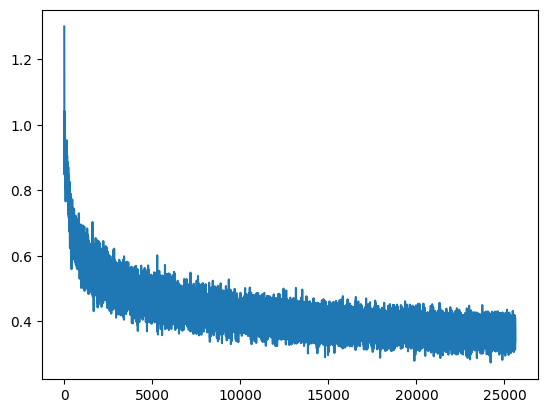

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

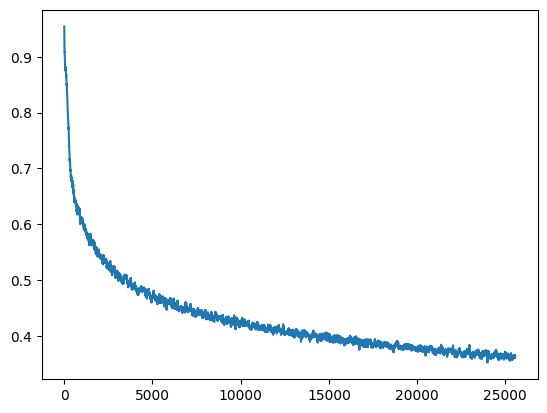

In [ ]:
window_size = 50

# Create normalized kernel
kernel = jnp.ones(window_size) / window_size

# Apply convolution
smoothed = jnp.convolve(jnp.array(losses), kernel, mode="valid")

plt.plot(smoothed)

## Generate

In [ ]:
rngs = nnx.Rngs(10) # tweak the seed here to try different generations
string = ""

ix = 0
for ix in range(128):
    y = transformer(encode(string).reshape(1, -1))
    logits = y[0, ix]
    # sample
    next_val = jax.random.choice(key=rngs(), a=n_vocab, p=jnp.exp(logits))
    if next_val == 2:
        break
    character = chr(next_val + 27)
    string += character
    print(string)

A
Ay
Ay,
Ay, 
Ay, t
Ay, th
Ay, the
Ay, then
Ay, then 
Ay, then k
Ay, then ke
Ay, then kee
Ay, then keep
Ay, then keep 
Ay, then keep t
Ay, then keep th
Ay, then keep the
Ay, then keep the 
Ay, then keep the w
Ay, then keep the we
Ay, then keep the wer
Ay, then keep the were
Ay, then keep the were.
Ay, then keep the were. 
Ay, then keep the were. T
Ay, then keep the were. Th
Ay, then keep the were. The
Ay, then keep the were. The 
Ay, then keep the were. The w
Ay, then keep the were. The wa
Ay, then keep the were. The war
Ay, then keep the were. The warr
Ay, then keep the were. The warra
Ay, then keep the were. The warran
Ay, then keep the were. The warrant
Ay, then keep the were. The warrant 
Ay, then keep the were. The warrant i
Ay, then keep the were. The warrant in
Ay, then keep the were. The warrant in 
Ay, then keep the were. The warrant in t
Ay, then keep the were. The warrant in th
Ay, then keep the were. The warrant in the
Ay, then keep the were. The warrant in the 
Ay, then ke